# Homework 7

## Exercise 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import urllib

from primesieve import nth_prime

In [2]:
random.seed(3536)

In [45]:
class HashTable:
    
    def __init__(self, m, p):
        self.m = m
        self.p = p
        self.table = [None] * m
        self.a = random.randint(1, p - 1)
        self.b = random.randint(0, p - 1)
        
    def get_coefs(self):
        return self.a, self.b
    
    def set_coefs(self, a, b):
        self.a = a
        self.b = b
        
    def hash_(self, key):
        return ((self.a * key + self.b) % self.p) % self.m
    
    def insert(self, keys):
        for key in keys:
            index = self.hash_(key)
        
            if self.table[index] is None:
                self.table[index] = [key]
            else:
                self.table[index].append(key)
        
    def get_collisions_num(self):
        n = 0
        
        for slot in self.table:
            if slot is not None and len(slot) > 1:
                n += len(slot) - 1
        
        return n
    
    def get_max_collisions(self):
        max_ = np.max([len(e) for e in self.table if e is not None])
        return max_ - 1

Let's check if our hash table works properly. Choose constants $p=17$ and $m=6$.

In [39]:
p = 17
m = 6

h57 = HashTable(m, p)
h57.set_coefs(5, 7)
print(f"h(3) = {h57.hash_(3)} (should be 5).")

h34 = HashTable(m, p)
h34.set_coefs(3, 4)
print(f"h(28) = {h34.hash_(28)} (should be 3).")

h102 = HashTable(m, p)
h102.set_coefs(10, 2)
print(f"h(3) = {h102.hash_(3)} (should be 3).")

h(3) = 5 (should be 5).
h(28) = 3 (should be 3).
h(3) = 3 (should be 3).


The universal hashing works fine! Let's proceed with plots.

In [40]:
def get_data(url):
    data = []
    
    with urllib.request.urlopen(url) as file:
        for line in file:
            data.append(int(line))
    
    return data

In [41]:
def test_collisions(n_iterations, table_size, keys):
    results = [[]] * n_iterations
    
    for i in range(n_iterations):
        # the 200_000th prime number is 2_750_159
        p = nth_prime(random.randint(200_000, 1_000_000))
        
        table = HashTable(table_size, p)
        table.insert(keys)
        
        results[i] = {'total': table.get_collisions_num(), 
                      'max': table.get_max_collisions(),
                      'coefs': (table_size, p, table.get_coefs()[0], table.get_coefs()[1])
                     }
    
    return results

In [42]:
def plot_collisions_bars(sizes, n_collisions):
    plt.rcParams["figure.figsize"] = (10, 8)
    plt.xlabel('table size')
    plt.ylabel('average number of collisions')
    plt.title('Average number of collisions for hash tables with random parameters')

    labels = [str(size) for size in sizes]
    rects = plt.bar(labels, n_collisions, color=['darkred', 'darkblue', 'darkgreen', 'darkmagenta'])
    plt.bar_label(rects, padding=3)

    plt.tight_layout()
    plt.show()

In [43]:
keys = get_data('https://courses.cs.ut.ee/MTAT.03.238/2022_fall/uploads/Main/1000_keys.txt')
print(len(keys))

1000


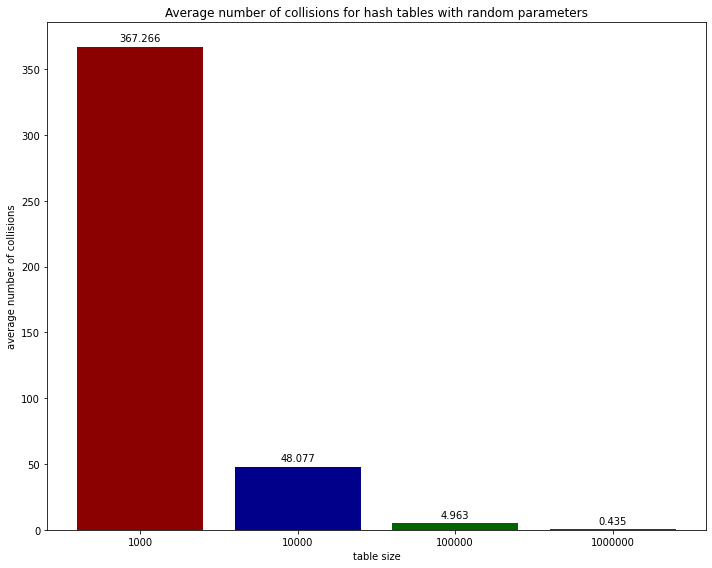

In [49]:
sizes = [1000, 10_000, 100_000, 1_000_000]
n_iterations = 1000
results = []
collisions = []

for size in sizes:
    results.append(test_collisions(n_iterations, size, keys))
    mean = np.mean([result['total'] for result in results[-1]])
    collisions.append(mean)
    
plot_collisions_bars(sizes, collisions)

## Exercise 2

Using the same results, let's find the hash function which produced the most collisions and the hash function that overflowed a slot the most.

In [53]:
def hash_function_to_str(hash_):
    m = hash_[0]
    p = hash_[1]
    a = hash_[2]
    b = hash_[3]
    
    return f"(({a} * k + {b}) mod {p}) mod {m}"

In [55]:
max_hash = max([e for result in results for e in result], key=lambda k: k['total'])
max_slot_hash = max([e for result in results for e in result], key=lambda k: k['max'])

print(f"Hash function '{hash_function_to_str(max_hash['coefs'])}' produces the maximal number of collisions: {max_hash['total']}.")
print(f"Hash function '{hash_function_to_str(max_slot_hash['coefs'])}' produces the most overflowed slot with {max_slot_hash['max']} collisions.")

Hash function '((1822324 * k + 2320377) mod 6282701) mod 1000' produces the maximal number of collisions: 397.
Hash function '((2874754 * k + 5871532) mod 7368037) mod 1000' produces the most overflowed slot with 8 collisions.


Let's see how maximum number of collisions per slot is spread over the sets of random hash functions with $m_1 = 1000$ and $m_2 = 10000$.

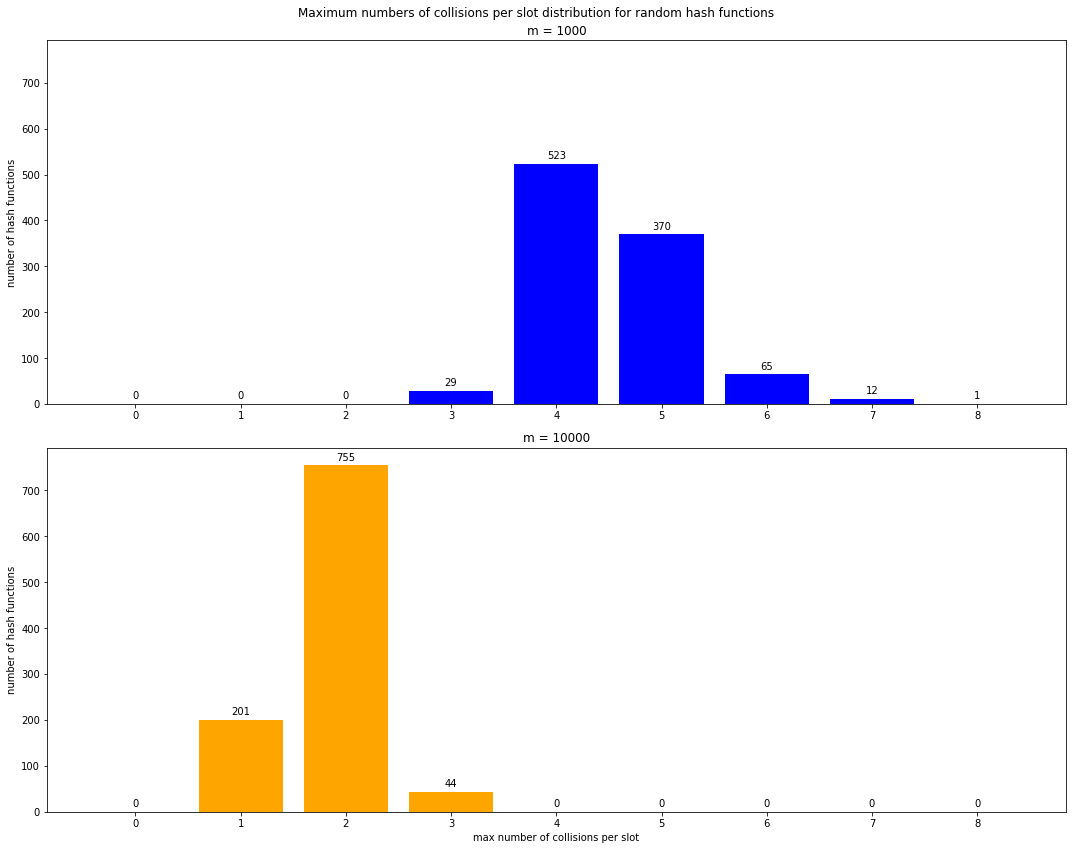

In [105]:
distribution_1000 = np.bincount([result['max'] for result in results[0]])
distribution_10000 = np.bincount([result['max'] for result in results[1]])
# for graphical purposes
distribution_10000 = np.concatenate([distribution_10000, np.zeros(len(distribution_1000) - len(distribution_10000))])

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12), sharey=True)
fig.suptitle('Maximum numbers of collisions per slot distribution for random hash functions')

labels = [str(i) for i in range(len(distribution_1000))]
x = np.arange(len(distribution_1000))

rects1 = ax1.bar(x, distribution_1000, color='blue')
ax1.set_title('m = 1000')
ax1.set_ylabel('number of hash functions')
ax1.set_xticks(x, labels)
ax1.bar_label(rects1, padding=3)

labels = [str(i) for i in range(len(distribution_10000))]
x = np.arange(len(distribution_10000))

rects2 = ax2.bar(x, distribution_10000, color='orange')
ax2.set_title('m = 10000')
ax2.set_ylabel('number of hash functions')
ax2.set_xlabel('max number of collisions per slot')
ax2.set_xticks(x, labels)
ax2.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

From the plots, we can conclude that for $m = 1000$ a randomly picked hash function will most probably give 4 collisions in some slot. So, it is relatively easy to set the hash function parameters badly. In case of $m = 10000$, the most probable hash function will produce at most 2 collisions in some slot. Thus, it is going to be hard to choose a hash function that will produce 4 collisions per slot. With increase of $m$, the properties of hash functions get better.

So far, we have chosen parameters of universal hash functions properly. The most important thing is to pick $p$ prime. Otherwise, we will get way more collisions. Let's ensure that.

In [108]:
m = 10_000
# prime
p1 = 16339
# 2^14
p2 = 16384
a = 1000
b = 111

h1 = HashTable(m, p1)
h1.set_coefs(a, b)
h1.insert(keys)
print(f"Hash function with prime p produces {h1.get_collisions_num()} collisions.")

h2 = HashTable(m, p2)
h2.set_coefs(a, b)
h2.insert(keys)
print(f"Hash function with p as a power of 2 produces {h2.get_collisions_num()} collisions.")

Hash function with prime p produces 53 collisions.
Hash function with p as a power of 2 produces 332 collisions.


Q.E.D.

## Exercise 3

**Static Hashing** uses a single hash function, and this hash function is fixed and computes destination bucket for a given key using the fixed number of locations/buckets in the hash table. This does not mean that the hash table that uses static hashing can’t be reorganized. It can still be reorganized by adding more number of buckets to the hash table. This would require:
* A new hash function that embraces the new size of hash table.
* Redistribution of ALL records stored in the hash table. Each record has to be touched and passed to the hash function to determine the new location/bucket. It is still possible that a record remains in the same bucket as it was before reorganization. But, hash function computation is definitely required for all the items in the hash table.
  
**Dynamic Hashing** tends to solve such problems:

* It gives the ability to design a hash function that is automatically changed underneath when the hash table is resized.
* Secondly, there is no need to recalculate the new bucket address for all the records in the hash table..
* This implies that rehash or redistribution is limited only to the particular bucket that is being split. There is absolutely no need to touch items in all the other buckets in the hash table.

**Extendible Hashing** is a *dynamic hashing* method wherein directories, and buckets are used to hash data. It is an aggressively flexible method in which the hash function also experiences dynamic changes. 

The main features in this hashing technique are:
* **Directories**: The directories store addresses of the buckets in pointers. An id is assigned to each directory which may change each time when Directory Expansion takes place.
* **Buckets**: The buckets are used to hash the actual data.
  
**Basic Structure of Extendible Hashing:**
<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190806160015/Basic-Structure-of-Extendible-Hashing.png'>
  
**Basic Working of Extendible Hashing:**
* **Step 1** – Analyze Data Elements: Data elements may exist in various forms eg. Integer, String, Float, etc.. Currently, let us consider data elements of type integer. eg: 49.
* **Step 2** – Convert into binary format: Convert the data element in Binary form. For string elements, consider the ASCII equivalent integer of the starting character and then convert the integer into binary form. Since we have 49 as our data element, its binary form is 110001.
* **Step 3** – Check Global Depth of the directory. Suppose the global depth of the Hash-directory is 3.
* **Step 4** – Identify the Directory: Consider the ‘Global-Depth’ number of LSBs in the binary number and match it to the directory id. Eg. The binary obtained is: 110001 and the global-depth is 3. So, the hash function will return 3 LSBs of 110001 viz. 001.
* **Step 5** – Navigation: Now, navigate to the bucket pointed by the directory with directory-id 001.
* **Step 6** – Insertion and Overflow Check: Insert the element and check if the bucket overflows. If an overflow is encountered, go to step 7 followed by Step 8, otherwise, go to step 9.
* **Step 7** – Tackling Over Flow Condition during Data Insertion: Many times, while inserting data in the buckets, it might happen that the Bucket overflows. In such cases, we need to follow an appropriate procedure to avoid mishandling of data. First, Check if the local depth is less than or equal to the global depth. Then choose one of the cases below. 
    * **Case1**: If the local depth of the overflowing Bucket is equal to the global depth, then Directory Expansion, as well as Bucket Split, needs to be performed. Then increment the global depth and the local depth value by 1. And, assign appropriate pointers. Directory expansion will double the number of directories present in the hash structure.
    * **Case2**: In case the local depth is less than the global depth, then only Bucket Split takes place. Then increment only the local depth value by 1. And, assign appropriate pointers.
* **Step 8** – Rehashing of Split Bucket Elements: The Elements present in the overflowing bucket that is split are rehashed w.r.t the new global depth of the directory.
* **Step 9** – The element is successfully hashed.

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190806160342/Basic-Working-of-Extendible-Hashing.png'>
  
**Handling the Overflow:**
<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190803103752/OverFlow3.png'>
  
**Advantages of Extendible Hashing:**
* Data retrieval is less expensive (in terms of computing).
* No problem of Data-loss since the storage capacity increases dynamically.
* With dynamic changes in hashing function, only associated old values are rehashed w.r.t the new hash function.
  
**Limitations Of Extendible Hashing:** 
* The directory size may increase significantly if several records are hashed on the same directory while keeping the record distribution non-uniform.
* Size of every bucket is fixed.
* Memory is wasted in pointers when the global depth and local depth difference becomes drastic.
* This method is complicated to code.  
  
  
**Resources:**
* https://loonytek.com/2016/05/17/extendible-hashing/
* https://www.geeksforgeeks.org/extendible-hashing-dynamic-approach-to-dbms/

## Exercise 4

In [33]:
from collections import Counter
from functools import partial

In [21]:
def lose_lose(string, bits):
    result = 0
    mask = (1 << bits) - 1
    
    for c in string:
        result = (result + ord(c)) & mask
    return result


def sdbm(string, bits):
    result = 0
    mask = (1 << bits) - 1
    
    for c in string:
        result = (ord(c) + (result << 6) + (result << 16) - result) & mask
    
    return result

In [5]:
def parse_words(url):
    words = []
    
    with urllib.request.urlopen(url) as file:
        words = file.read().splitlines()
    for i in range(len(words)):
        words[i] = words[i].decode('UTF-8')
    
    return words

In [55]:
def test_hashing(hash_, data):
    hashed = [hash_(word) for word in data]
    counts = Counter(hashed)

    max_ = max(counts, key=counts.get)
    total = sum([value for value in counts.values() if value > 1])
    
    print(f"Total number of colliding integers is {total}, "
          f"the most occupied value has {counts[max_] if counts[max_] > 1 else 0} integers colliging.")

In [8]:
words = parse_words('https://raw.githubusercontent.com/dwyl/english-words/master/words.txt')
print(len(words))

466550


In [56]:
lose_32bit = partial(lose_lose, bits=32)
lose_64bit = partial(lose_lose, bits=64)

print('LOSE LOSE STRING HASHING (CHARACTERS ADDITION)\n')
print('32 bit integers case:')
test_hashing(lose_32bit, words)
print('\n64 bit integers case:')
test_hashing(lose_64bit, words)

LOSE LOSE STRING HASHING (CHARACTERS ADDITION)

32 bit integers case:
Total number of colliding integers is 466389, the most occupied value has 1123 integers colliging.

64 bit integers case:
Total number of colliding integers is 466389, the most occupied value has 1123 integers colliging.


In [57]:
sdbm_32bit = partial(sdbm, bits=32)
sdbm_64bit = partial(sdbm, bits=64)

print('SDBM STRING HASHING\n')
print('32 bit integers case:')
test_hashing(sdbm_32bit, words)
print('\n64 bit integers case:')
test_hashing(sdbm_64bit, words)

SDBM STRING HASHING

32 bit integers case:
Total number of colliding integers is 50, the most occupied value has 2 integers colliging.

64 bit integers case:
Total number of colliding integers is 0, the most occupied value has 0 integers colliging.


So, the second hashing (with all its simplicity) is much better and produces no collisions on 64-bit words.

## Exercise 5

The **Bloom Filters** is basically a set of hash tables. It inserts hashed data (actually, not data, but 'True' to mark that a slot is not empty) into each table with its own size, and it neither counts collisions nor keeps track of keys. So, what we get is a **probabilistic data structure**. When checking if some element is present, we check whether it is present in all the tables and subsequently we **may get false positives but never false negatives**.  
  
  
This data structure happens to be very useful for storing sequences: you can iterate through the sequence and insert each word. Then you can use Bloom filters to continue a sequence by its beginning. This techinque demonstrates a brilliant performance for **assembling DNA sequence**. This was the motivation of Titus Brown lecture.